In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
qc_raw = pd.read_csv("snap_qc_data_2017to2023.csv", encoding="latin1")

cols = ["State", "Year", "Error Responsibility"]
qc = qc_raw[cols].copy()
print(qc.head(5))

         State  Year Error Responsibility
0  Connecticut  2017     Technical Errors
1  Connecticut  2017        Client Errors
2  Connecticut  2017        Client Errors
3  Connecticut  2017        Client Errors
4  Connecticut  2017        Client Errors


In [16]:
# 统一大小写、去空格
qc["Error Responsibility"] = (
    qc["Error Responsibility"]
    .astype(str)
    .str.strip()
    .str.lower()
)

qc = qc[qc["Error Responsibility"].str.lower() != "nan"]

# 查看有哪些类型
print(qc["Error Responsibility"].value_counts())


Error Responsibility
agency errors       33462
client errors       28548
technical errors    10047
Name: count, dtype: int64


In [18]:
counts = (
    qc.groupby(["State", "Year", "Error Responsibility"])
    .size()
    .reset_index(name="count")
)
print(counts.head())


     State  Year Error Responsibility  count
0  Alabama  2017        agency errors     40
1  Alabama  2017        client errors     42
2  Alabama  2017     technical errors      8
3  Alabama  2018        agency errors     43
4  Alabama  2018        client errors     51


In [20]:
pivot = counts.pivot(index=["State", "Year"], columns="Error Responsibility", values="count").fillna(0)

# 计算每年总错误数
pivot["total"] = pivot.sum(axis=1)

# 计算每类责任占比
for col in [c for c in pivot.columns if c not in ["total"]]:
    pivot[f"{col}_ratio"] = pivot[col] / pivot["total"]

print(pivot.head())


Error Responsibility  agency errors  client errors  technical errors  total  \
State   Year                                                                  
Alabama 2017                   40.0           42.0               8.0   90.0   
        2018                   43.0           51.0              16.0  110.0   
        2019                   34.0           75.0               7.0  116.0   
        2020                   39.0           54.0               5.0   98.0   
        2021                   20.0           21.0               2.0   43.0   

Error Responsibility  agency errors_ratio  client errors_ratio  \
State   Year                                                     
Alabama 2017                     0.444444             0.466667   
        2018                     0.390909             0.463636   
        2019                     0.293103             0.646552   
        2020                     0.397959             0.551020   
        2021                     0.465116         

In [30]:
avg_resp = pivot.groupby("State")[[c for c in pivot.columns if c.endswith("_ratio")]].mean().reset_index()

# 对结果进行排序（例如按 client error 比例降序）
avg_resp = avg_resp.sort_values("agency errors_ratio", ascending=False)
print(avg_resp.head())


Error Responsibility           State  agency errors_ratio  \
52                           Wyoming             0.702234   
41                    South Carolina             0.701928   
15                           Indiana             0.688426   
42                      South Dakota             0.664387   
24                         Minnesota             0.659937   

Error Responsibility  client errors_ratio  technical errors_ratio  
52                               0.117481                0.180285  
41                               0.230623                0.067449  
15                               0.200202                0.111372  
42                               0.159339                0.176274  
24                               0.268726                0.071337  


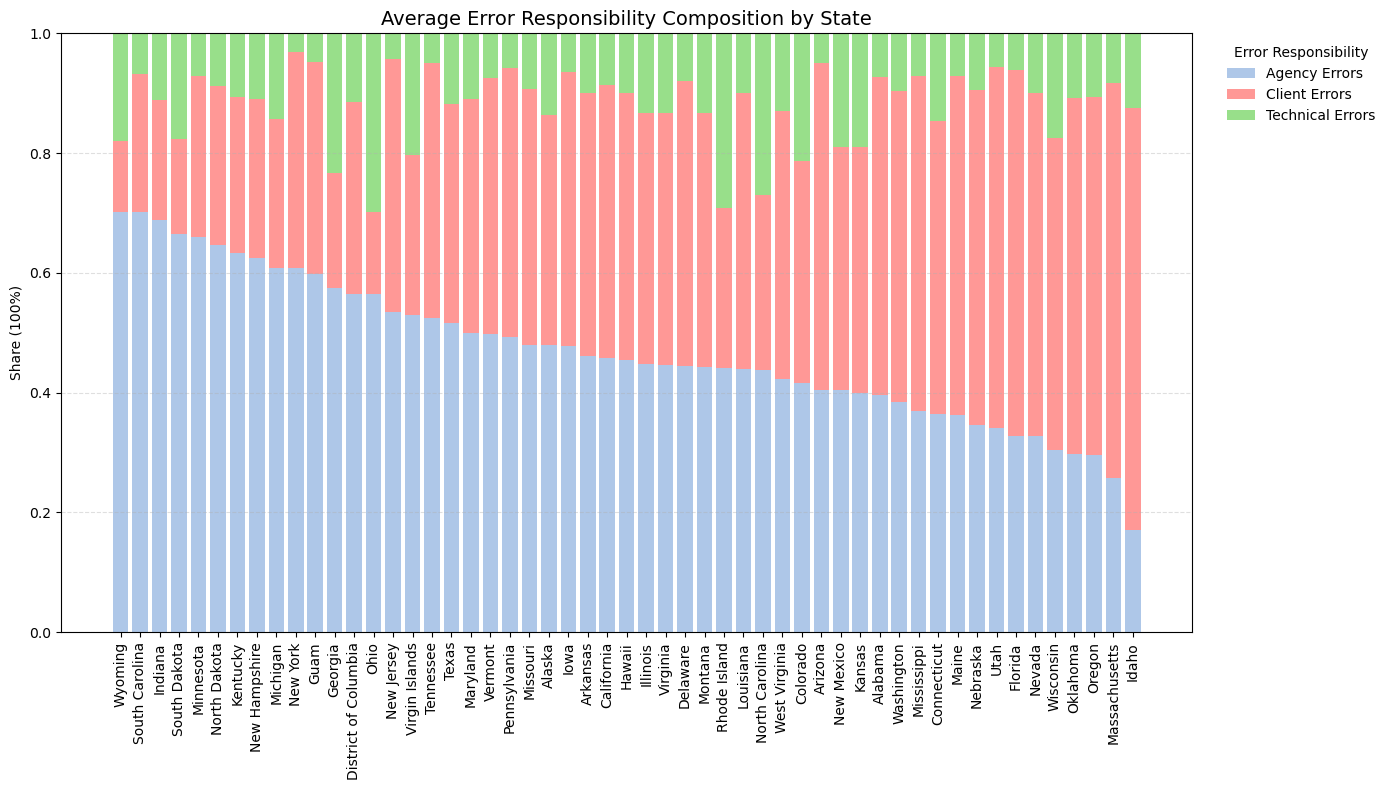

In [35]:
# 提取比例列
ratio_cols = [c for c in avg_resp.columns if c.endswith("_ratio")]

# 柔和配色
colors = ["#aec7e8", "#ff9896", "#98df8a", "#c7c7c7"]  # 可根据类别数调整

# 绘图
plt.figure(figsize=(14, 8))

bottom = np.zeros(len(avg_resp))
for i, col in enumerate(ratio_cols):
    plt.bar(
        avg_resp["State"],
        avg_resp[col],
        bottom=bottom,
        label=col.replace("_ratio", "").title(),
        color=colors[i % len(colors)],
    )
    bottom += avg_resp[col]

plt.xticks(rotation=90)
plt.ylabel("Share (100%)")
plt.title("Average Error Responsibility Composition by State", fontsize=14)
plt.ylim(0, 1)
plt.legend(title="Error Responsibility", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("average_error_responsibility_composition.png", dpi = 300, bbox_inches = "tight")
plt.show()
